<a href="https://colab.research.google.com/github/gnitnaw/Programs/blob/master/Chapter6/peakskernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.7.12


# Example 6.13
## Import modules

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from numpy.linalg import norm
print(np.__version__)

1.19.5


In [3]:
def nbe(a,b):  
    numd = len(a) 
    na = a.copy()
    carry= True
    for i in reversed(range(numd)):
        if carry:
            if na[i] == b-1:
                na[i] = 0
            else:
                na[i] = na[i] + 1
                carry = False            
    if carry:
       na.insert(0,1)        
    return(na)

def vdc(b,N):
    out = np.zeros((N,1))
    numd = np.ceil(np.log(N)/np.log(b))
    bb = 1/b**np.arange(1,numd+1)
    a = []
    out[0] = 0
    for i in range(1,N):
        a = nbe(a,b)
        #print(a)
        ar = a[::-1]
        #print(ar, bb[0:len(ar)])
        out[i] = np.sum(ar*bb[0:len(ar)])
    return(out)

def halton(b,N):
   dim = len(b);
   out = np.zeros((N,dim))
   for i in range(0,dim):
      out[:,i] = vdc(b[i],N).reshape((N,))
   return(out)

def hammersley(b,N):
    dim = len(b);
    out = np.zeros((N,dim))
    h = halton(b[0:dim-1],N-1)
    h = h.reshape((N-1,dim-1))
    out[1:N,1:dim] = h
    out[:,0] = np.arange(N)/N
    return(out)

b = [2,3,5]
N = 20

## Set random seed

In [4]:
np.random.seed(1357)

## Original Program

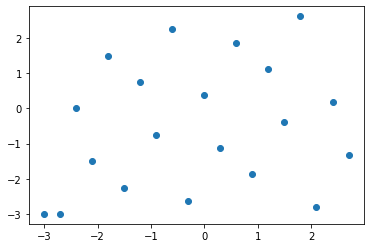

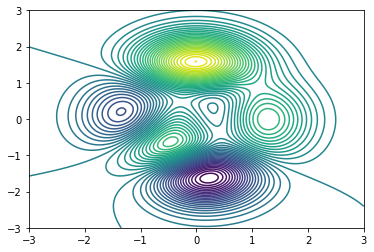

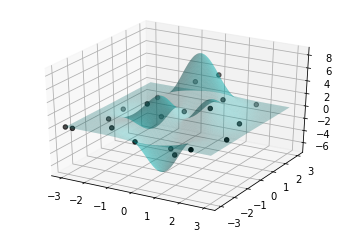

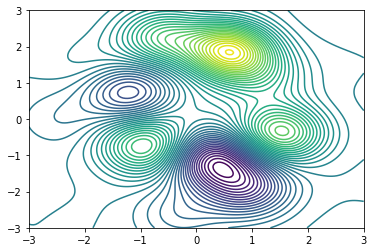

In [5]:
def peaks(x,y):
    z =  (3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) 
          - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2)
          - 1/3 * np.exp(-(x+1)**2 - y**2)) 
    return(z)
 
n = 20
x = -3 + 6*hammersley([2,3],n)
plt.plot(x.T[0], x.T[1], 'o')
plt.show()

z = peaks(x[:,0],x[:,1])
xx, yy = np.mgrid[-3:3:150j,-3:3:150j]
zz = peaks(xx,yy)
plt.contour(xx,yy,zz,levels=50)

fig=plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.plot_surface(xx,yy,zz,rstride=1,cstride=1,color='c',alpha=0.3,linewidth=0)
ax.scatter(x[:,0],x[:,1],z,color='k',s=20)
plt.show()

sig2 = 0.3 # kernel parameter
def k(x,u):
    return(np.exp(-0.5*norm(x- u)**2/sig2))
K = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        K[i,j] = k(x[i,:],x[j])
alpha = np.linalg.solve(K@K.T, K@z)       

N, = xx.flatten().shape

Kx = np.zeros((n,N))
for i in range(n):
    for j in range(N):
        Kx[i,j] = k(x[i,:],np.array([xx.flatten()[j],yy.flatten()[j]]))

g = Kx.T @ alpha
dim = np.sqrt(N).astype(int)
yhat = g.reshape((dim,dim))
plt.contour(xx,yy,yhat,levels=50)

## Find the best sigma^2

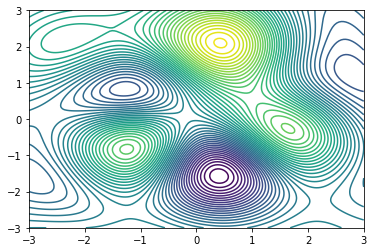

In [6]:
def kk(x, u, s2):
    return(np.exp(-0.5*norm(x- u)**2/s2))
K = np.zeros((n,n))

Sig2 = np.linspace(0.1, 2.1, 1000)
loss = np.zeros(Sig2.shape[0])

for k in range(Sig2.shape[0]):
    for i in range(n):
        for j in range(n):
            K[i,j] = kk(x[i,:],x[j], Sig2[k])

    alpha = np.linalg.solve(K@K.T, K@z)       

    y_hat = x @ x.T @ alpha
    loss[k] = np.sum((y_hat-z)**2)/n

sig2_best = Sig2[np.argmin(loss)]

K = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        K[i,j] = kk(x[i,:],x[j], sig2_best)
alpha = np.linalg.solve(K@K.T, K@z)       

N, = xx.flatten().shape

Kx = np.zeros((n,N))
for i in range(n):
    for j in range(N):
        Kx[i,j] = kk(x[i,:],np.array([xx.flatten()[j],yy.flatten()[j]]), sig2_best)

g = Kx.T @ alpha
dim = np.sqrt(N).astype(int)
yhat = g.reshape((dim,dim))
plt.contour(xx,yy,yhat,levels=50)
plt.show()
